# Intermittent control as a model of mouse movements

## Reduced parameter set


This notebook provides visualisations of the Intermittent Control (IC) parameters (reduced set) which were obtained from an optimisation procedure based on an experimental pointing task. The data file used by this notebook contains the optimised parameters for each condition (8 in total) for the 12 participants. In the file, the values of all the parameters obtained for a particular slice are listed and grouped according to target distance and width. The file was generated in MATLAB and it is imported to Python using a Pandas dataframe.

This notebook is part of the supplemental material for publication in ACM Transactions on Computer-Human Interaction (https://dl.acm.org/journal/tochi)

This work is based on the results of the following paper:

- Müller, Jörg, Antti Oulasvirta, and Roderick Murray-Smith. "Control
theoretic models of pointing." ACM Transactions on Computer-Human
Interaction (TOCHI) 24, no. 4 (2017): 27.

### Requirements

Please install the CRETools-0.1.0 package before running this jupyter
notebook as follows:

* Go to the folder CRETools-0.1.0 and build the package with: python setup.py sdist
* In the same folder, use the following line to install it: python setup.py install

The notebook also needs the following dependencies:

* umap-learn (https://pypi.org/project/umap-learn/)
* numpy (https://numpy.org/)
* seaborn (https://seaborn.pydata.org/)
* pandas (https://pandas.pydata.org/)
* scipy (https://www.scipy.org/)
* universal-divergence (https://pypi.org/project/universal-divergence/)

# 1. Load the reduced set of optimised parameters

The first step is to read the data file (opt_data_min_20201215T232437.mat) that contains all the parameters for all participants. Once loaded, a Pandas dataframe (df) is created. The following cell assigns names to each column of the dataframe and performs some necessary operations on the data.

The parameters that were extracted from the optimisation procedure are: 

- 1) Thresholds $q$. 
- 2) Mismatch gain $A_p$.
- 3) The first to elements in the diagonal of the LQR design matrix $Q_c$, which weights the states of the model. This diagonal contains 4 elements and they are labelled as $Q_{c_1}$, $Q_{c_2}$, $Q_{c_3}$ and $Q_{c_4}$. But only $Q_{c_1}$, $Q_{c_2}$ were optimised.

Since the LQR procedure results in the generation of a set of controller gains which are used to generate a control signal via state-feedback, they were included in the dataframe as $k_1$, $k_2$, $k_3$ and $k_4$.


In [1]:
# --- Load libraries
from __future__ import print_function
from universal_divergence import estimate
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.cm as cm
import seaborn as sns
import pandas as pd
import umap
import copy
import scipy.io as spio
from scipy import stats
from sklearn import preprocessing
from cre import io as loader

%matplotlib inline

# --- Paper context for Seaborn
sns.set(style='white', context='paper', font_scale=1.5, rc={'figure.figsize':(12, 8), 'figure.facecolor':'w'})

# --- Load data file (generated using matlab)
df = loader.loadmat(r'data_files/opt_data_min_20201215T232437.mat') # All participants

# --- Create pandas dataframe df
df = pd.DataFrame(df['df'])
df.columns = ["Participant", "Slice", "Threshold", "Ap","OL","Qc1","Qc2","Qc3","Qc4","Qo","k1","k2","k3","k4","J_slice","J_trial","Distance","Width","ID"]

# --- Change the mismatch gain to reflect the difference with respect to the true plant.
df['Ap'] = 1-df['Ap']

# --- Convert ID, distance, width, and Participant to integers only
df['ID'] = df['ID'].astype(int)
df['Distance'] = df['Distance'].astype(int)
df['Width'] = df['Width'].astype(int)
df['Participant'] = df['Participant'].astype(int)

# --- Removing large thresholds and OL's
df = df.drop(df[df.OL > 0.06].index)
df = df.drop(df[df.Ap < -0.3].index)
df = df.drop(df[df.J_trial > 0.04].index)
df = df.drop(df[df.J_slice > 0.025].index)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# 2. Optimisation results

In this section, general violin plots are obtained to give an overall view of the resulting set of parameters from the optimisation process. These figures include parameters for all participants and conditions. The figures are organised as follows:

- 1 by 4 grid showing the first two elements in $Q_c$, followed by $A_p$ and $q$.
- 1 by 4 grid showing the four controller gains ($k_1$, $k_2$, $k_3$, $k_4$).
- 1 by 2 grid with value of the cost function used during the training of each slice vs the value of the cost function when the optimised parameters of each slice are used to run a simulation over the entire trial (not just the slice).

The x axis of all figures shows the four ID's of the experiment. Each side of the violin plot corresponds to the distribution of one of the two different distances between targets. The distribution on the left side is for a distance of 212mm, the one on the right is for 353mm.

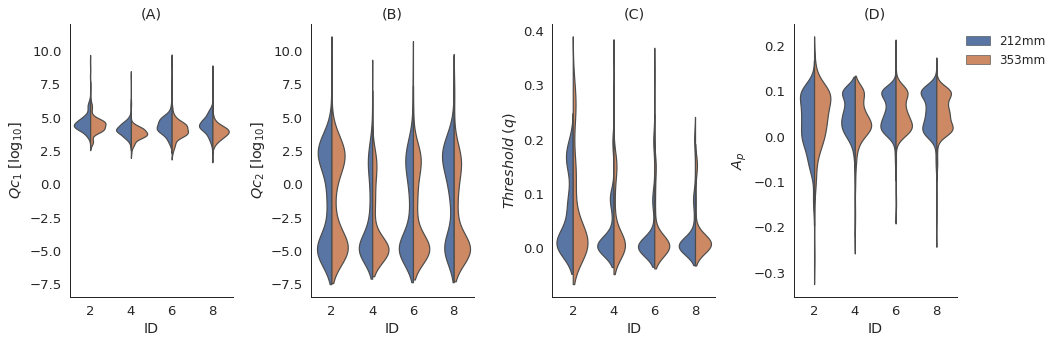

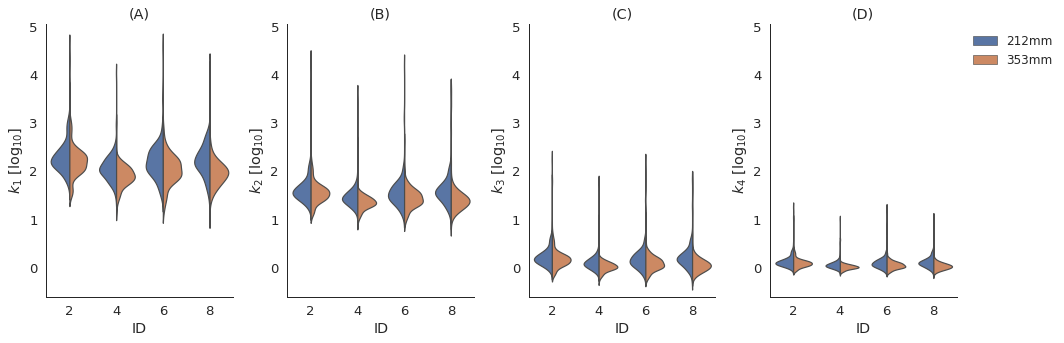

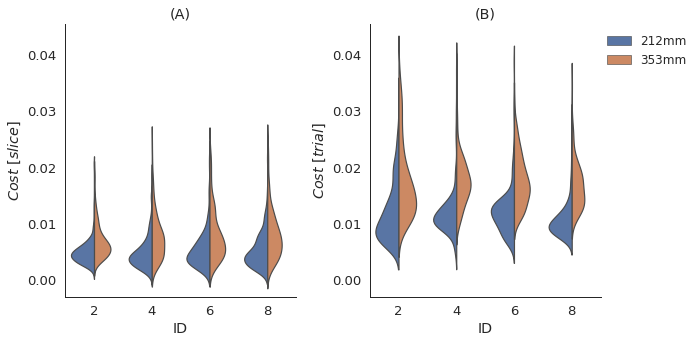

In [2]:
# --- These variables control the appearance of the violin plots
bw_kde = 'silverman'    # Automatic bandwidth selection by Silverman's method.
cut_data = 2;           # 2 is the default
y_suptitle = 1.02
save_violin = False     # Save violin plot figure or not.
    
# --- Special Dataframes for Violin plots
dfv = copy.deepcopy(df)

# --- Logs of Q's and K's
dfv['Qc1'] = np.log10(dfv['Qc1']); dfv['Qc2'] = np.log10(dfv['Qc2'])
dfv['Qc3'] = np.log10(dfv['Qc3']); dfv['Qc4'] = np.log10(dfv['Qc4'])
dfv['k1'] = np.log10(dfv['k1']); dfv['k2'] = np.log10(dfv['k2'])
dfv['k3'] = np.log10(dfv['k3']); dfv['k4'] = np.log10(dfv['k4'])
dfv['Qo'] = np.log10(dfv['Qo'])

# --- Labels
title_labels = ['A','B','C','D']; 
axis_labels_Qc = ['$Qc_1$ $[\log_{10}]$','$Qc_2$ $[\log_{10}]$','$Qc_3$ $[\log_{10}]$','$Qc_4$ $[\log_{10}]$']
axis_labels_k = ['$k_1$ $[\log_{10}]$','$k_2$ $[\log_{10}]$','$k_3$ $[\log_{10}]$','$k_4$ $[\log_{10}]$']
axis_labels_ic = ['$Threshold$ $(q)$','$A_p$','$\Delta_{ol}^{min}$ $[sec]$','$Q_o$ $[\log_{10}]$']
axis_labels_J = ['$Cost$ $[slice]$','$Cost$ $[trial]$']

axis_labels_combined = ['$Qc_1$ $[\log_{10}]$','$Qc_2$ $[\log_{10}]$','$Threshold$ $(q)$','$A_p$']

# --- Definition of plotting functions
def violin_pars_row(params, df, cut_data, bw_kde, title_labels, axis_labels, par_sel, save_fig, width_fig):
    fig, axes = plt.subplots(figsize=(width_fig, 5))
    ymin_all = []; ymax_all = []; g_all = []
    for x in range(len(params)):
        plt.subplot(1,len(params),x+1)
        g = sns.violinplot(x="ID", y=params[x], hue="Distance", data=df, cut = cut_data, bw = bw_kde, split=True, inner=None)
        g_all.append(g)
        if x < len(params):    
            plt.title('('+title_labels[x]+')')
        if par_sel != 'ic':
            y_min, y_max = g.axes.get_ylim()
            ymin_all.append(y_min); ymax_all.append(y_max)
        cax = plt.gca()
        cax.set_ylabel(axis_labels[x])
        cax.spines["right"].set_visible(False)
        cax.spines["top"].set_visible(False)
        cax.legend_ = None
        if x == len(params)-1:    
            plt.legend(['212mm', '353mm'], prop={'size': 12}, frameon=False, loc='upper center', bbox_to_anchor=(1.3, 1))
    if par_sel != 'ic':
        for y in range(len(params)):
            g_all[y].axes.set_ylim(min(ymin_all),max(ymax_all)) 
    fig.tight_layout()
    if save_fig == True:
        fig.savefig('violin_all_row_'+par_sel+'.eps',dpi=300)
        
def violin_pars_row_combined(params, df, cut_data, bw_kde, title_labels, axis_labels, save_fig, width_fig):
    fig, axes = plt.subplots(figsize=(width_fig, 5))
    ymin_all = []; ymax_all = []; g_all = []
    for x in range(len(params)):
        plt.subplot(1,len(params),x+1)
        g = sns.violinplot(x="ID", y=params[x], hue="Distance", data=df, cut = cut_data, bw = bw_kde, split=True, inner=None)
        g_all.append(g)
        if x < len(params):    
            plt.title('('+title_labels[x]+')')
        # if x < 2:
        y_min, y_max = g.axes.get_ylim()
        ymin_all.append(y_min); ymax_all.append(y_max)
        cax = plt.gca()
        cax.set_ylabel(axis_labels[x])
        cax.spines["right"].set_visible(False)
        cax.spines["top"].set_visible(False)
        cax.legend_ = None
        if x == len(params)-1:    
            plt.legend(['212mm', '353mm'], prop={'size': 12}, frameon=False, loc='upper center', bbox_to_anchor=(1.3, 1))
    # for y in range(len(params)):
    for y in range(2):    
        g_all[y].axes.set_ylim(min(ymin_all),max(ymax_all)) 
    fig.tight_layout()
    if save_fig == True:
        fig.savefig('violin_all_row_combined.eps',dpi=300)
        
def violin_cost(params, df, cut_data, bw_kde, title_labels, axis_labels, par_sel, save_fig, width_fig):    
    fig, axes = plt.subplots(figsize=(width_fig, 5))
    ymin_all = []; ymax_all = []; g_all = []
    for x in range(len(params)):
        plt.subplot(1,len(params),x+1)
        g = sns.violinplot(x="ID", y=params[x], hue="Distance", data=df, cut = cut_data, bw = bw_kde, split=True, inner=None)
        g_all.append(g)
        if x < len(params):    
            plt.title('('+title_labels[x]+')')
        y_min, y_max = g.axes.get_ylim()
        ymin_all.append(y_min); ymax_all.append(y_max)    
        cax = plt.gca()
        cax.set_ylabel(axis_labels_J[x])
        cax.spines["right"].set_visible(False)
        cax.spines["top"].set_visible(False)
        cax.legend_ = None
        if x == len(params)-1:    
            plt.legend(['212mm', '353mm'], prop={'size': 12}, frameon=False, loc='upper center', bbox_to_anchor=(1.2, 1))
    for y in range(len(params)):
        g_all[y].axes.set_ylim(min(ymin_all),max(ymax_all))    
    fig.tight_layout()
    if save_fig == True:
        fig.savefig('violin_all_'+par_sel+'.eps',dpi=300)
        
# save_violin = True
params = ['Qc1','Qc2','Threshold','Ap']; width_fig = 15
violin_pars_row_combined(params, dfv, cut_data, bw_kde, title_labels, axis_labels_combined, save_violin, width_fig)

# save_violin = False
# --- k plot row
params = ['k1','k2','k3','k4']; width_fig = 15
violin_pars_row(params, dfv, cut_data, bw_kde, title_labels, axis_labels_k, 'k', save_violin, width_fig)

# --- Cost plot
params = ['J_slice','J_trial']; width_fig = 10
violin_cost(params, dfv, cut_data, bw_kde, title_labels, axis_labels_J, 'J', save_violin, width_fig)



# 3. Low dimensional representation via Uniform Manifold Approximations (UMAP)

This section uses uniform manifold approximation reduction techniques to provide a low dimensional visualisation of the data. It is based on the umap-learn library for Python, available here: https://pypi.org/project/umap-learn/.

**Please run the following cell twice to eliminate the initial warnings (if any).**

In [3]:
# SETUP UMAP

# 1. FUNCTIONS & DEFAULTS -----------------------------------------------------

plt.rcParams.update({'figure.max_open_warning': 0})

# --- Load phase-plane trajectories from MATLAB
def phase_trajectories(part):
    pp_matlab = r'data_files/min_phase_planes/sim_mc_P'+part+'.mat'
    pp = spio.loadmat(pp_matlab)

    df_765 = []
    df_1275 = []
    for i in range(0, 8, 2):
        df_tmp = [pp['time_series'][i]['ysim'][0],
                  pp['time_series'][i]['vsim'][0]]
        df_765.append(df_tmp)
    for i in range(1, 9, 2):
        df_tmp = [pp['time_series'][i]['ysim'][0],
                  pp['time_series'][i]['vsim'][0]]
        df_1275.append(df_tmp)

    return df_765, df_1275

dfID = copy.deepcopy(df)

# 2. UMAP ---------------------------------------------------------------------

# --- General options
normalize_umap = True                              # Use normalized data
min_d = 1                                          # Minimum distance
n_comp = 2                                         # Number of components
n_neigh = 40                                       # Number of neighbors
met = 'minkowski'                                  # UMAP Metric
xlim_l = -0.23                                     # Limit for phase-planes
xlim_r = 0.23                                      # Limit for phase-planes
ylim_l = -2.5                                      # Limit for phase-planes
ylim_r = 2.5                                       # Limit for phase-planes
labels_size = 11                                   # Fontsize for axis labels
dist = ['765', '1275']                             # Distances
idss = ['2', '4', '6', '8']                        # Index of difficulty
participants = list(map(str, range(1, 13)))        # 12 participants

# --- Color palettes
palette_participant = sns.color_palette('Paired', n_colors=12)
palette_ID = sns.color_palette('tab10', n_colors=4)
palette_distance = sns.color_palette('tab10', n_colors=2)

# --- Dataframes and data processing
UMAP_pars_full = ['k1', 'k2', 'Ap', 'Threshold', 'ID', 'Distance', 'Participant']
dfUMAP_pars_full = pd.DataFrame(dfID, columns=UMAP_pars_full)

dfUMAP_pars_full['k1_log'] = np.log10(dfUMAP_pars_full['k1'])
dfUMAP_pars_full['k2_log'] = np.log10(dfUMAP_pars_full['k2'])
dfUMAP_pars_full['k1_norm'] = dfUMAP_pars_full['k1']
dfUMAP_pars_full['k2_norm'] = dfUMAP_pars_full['k2']

dfUMAP_pars_full[['k1_norm', 'k2_norm']] = preprocessing.normalize(dfUMAP_pars_full[['k1_norm', 'k2_norm']].T).T

dfUMAP_pars_full = dfUMAP_pars_full.drop(dfUMAP_pars_full[dfUMAP_pars_full.k1 > 1500].index)
dfUMAP_pars_full = dfUMAP_pars_full.drop(dfUMAP_pars_full[dfUMAP_pars_full.k2 > 1500].index)

UMAP_pars = ['k1', 'k2', 'Ap', 'Threshold']
dfUMAP_pars = pd.DataFrame(dfID, columns=UMAP_pars)

dfUMAP_pars = dfUMAP_pars.drop(dfUMAP_pars[dfUMAP_pars.k1 > 1500].index)
dfUMAP_pars = dfUMAP_pars.drop(dfUMAP_pars[dfUMAP_pars.k2 > 1500].index)

# --- Normalize data
if normalize_umap is True:
    dfUMAP_pars[['k1', 'k2', 'Ap', 'Threshold']] = preprocessing.normalize(dfUMAP_pars[['k1', 'k2', 'Ap', 'Threshold']].T).T
    
# --- Embeddings
dfID_umap = copy.deepcopy(dfUMAP_pars)

reducer = umap.UMAP(n_neighbors=n_neigh, min_dist=min_d, n_components=n_comp, metric=met)
embed_all = reducer.fit_transform(dfID_umap)

if n_comp == 1:
    x_umap = 'umap-one'
    y_umap = 'umap-one'
    x_label = 'UMAP axis 1'
    y_label = 'UMAP axis 1'
    dfID_umap[x_umap] = embed_all[:, 0]
else:
    x_umap = 'umap-one'
    y_umap = 'umap-two'
    x_label = 'UMAP axis 1'
    y_label = 'UMAP axis 2'
    dfID_umap[x_umap] = embed_all[:, 0]
    dfID_umap[y_umap] = embed_all[:, 1]

dfID_umap['ID'] = dfUMAP_pars_full['ID']
dfID_umap['Distance'] = dfUMAP_pars_full['Distance']
dfID_umap['Participant'] = dfUMAP_pars_full['Participant']

### 3.1 Two dimensional embedding coloured by ID, distance and participant

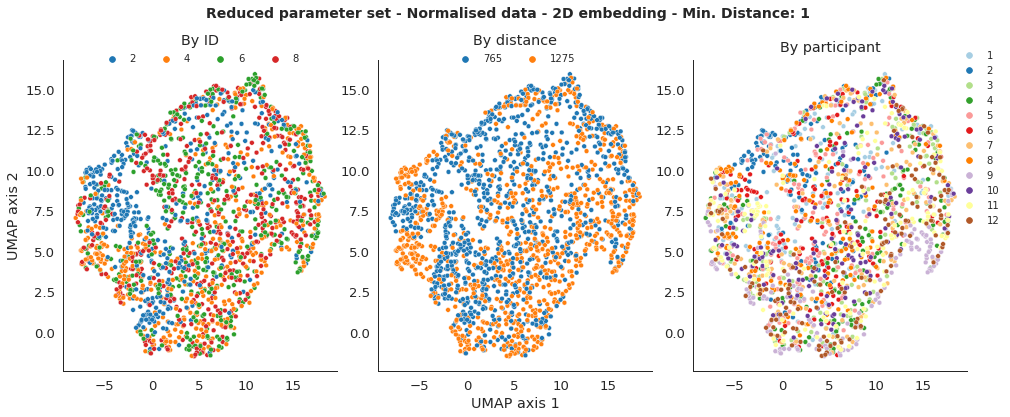

In [4]:
# FIGURE ---------------------------------------------------------------------

grid = plt.GridSpec(1, 3)
plt.subplots(figsize=(14, 6))

ax1 = plt.subplot(grid[0, 0])
sns.scatterplot(
    x=x_umap, y=y_umap,
    hue='ID',
    palette=palette_ID,
    data=dfID_umap,
    legend='full',
    ax=ax1)
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.set_title('By ID', y=1.03)
ax1.set_xlabel('')
ax1.set_ylabel(y_label)
ax1.legend(prop={'size': 10}, frameon=False, scatterpoints=1,
           markerscale=1.2, loc='upper center',
           bbox_to_anchor=(0.5, 1.05), ncol=4)

ax2 = plt.subplot(grid[0, 1])
sns.scatterplot(
    x=x_umap, y=y_umap,
    hue='Distance',
    palette=palette_distance,
    data=dfID_umap,
    legend='full',
    ax=ax2)
ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.set_title('By distance', y=1.03)
ax2.set_xlabel(x_label)
ax2.set_ylabel('')
ax2.legend(prop={'size': 10}, frameon=False, scatterpoints=1,
           markerscale=1.2, loc='upper center',
           bbox_to_anchor=(0.5, 1.05), ncol=2)

ax3 = plt.subplot(grid[0, 2])
sns.scatterplot(
    x=x_umap, y=y_umap,
    hue='Participant',
    palette=palette_participant,
    data=dfID_umap,
    legend='full',
    ax=ax3)
ax3.spines["right"].set_visible(False)
ax3.spines["top"].set_visible(False)
ax3.set_title('By participant', y=1.01)
ax3.set_xlabel('')
ax3.set_ylabel('')
ax3.legend(prop={'size': 10}, frameon=False, scatterpoints=1,
           markerscale=1.2, loc='center right',
           bbox_to_anchor=(1.15, 0.75), ncol=1)

plt.subplots_adjust(top=0.5)
plt.tight_layout()

if normalize_umap is True:
    plt.suptitle('Reduced parameter set - Normalised data - '+str(n_comp)+'D embedding - Min. Distance: '+str(min_d), fontsize=14, fontweight='bold', y=0.97)
else:
    plt.suptitle('Reduced parameter set - Raw data - '+str(n_comp)+'D embedding - Min. Distance: '+str(min_d), fontsize=14, fontweight='bold', y=0.97)


### 3.2 Two dimensional embedding coloured according to the value of the optimised parameters

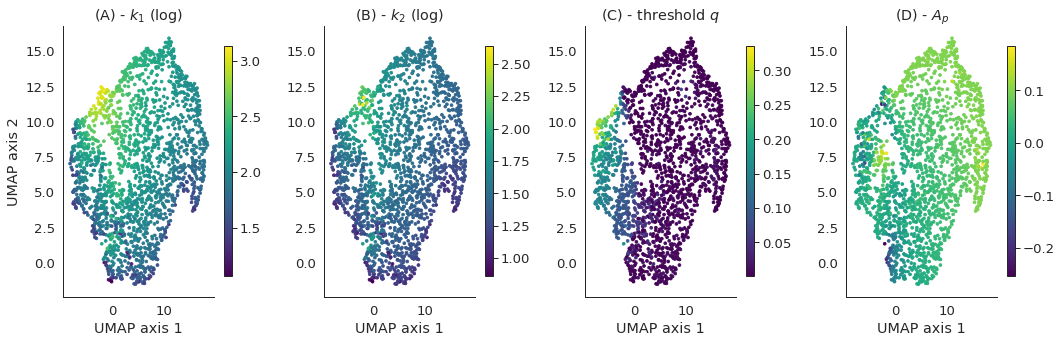

In [5]:
# FIGURE ---------------------------------------------------------------------

grid = plt.GridSpec(1, 4)
plt.subplots(figsize=(15, 5))
par_list = ['k1_log','k2_log','Threshold','Ap']
title_list = ['(A) - $k_1$ (log)', '(B) - $k_2$ (log)','(C) - threshold $q$','(D) - $A_p$']

for i in range(len(par_list)):
    ax = plt.subplot(grid[0, i])
    plt.scatter(dfID_umap[x_umap], dfID_umap[y_umap],
                s=8, c=dfUMAP_pars_full[par_list[i]], cmap='viridis')
    plt.colorbar(aspect=30, shrink=0.85)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.set_title(title_list[i])
    ax.set_xlabel(x_label)
    if i == 0:
        ax.set_ylabel(y_label)
    else:
        ax.set_ylabel('')
        
plt.tight_layout()

### 3.3 Two dimensional embedding coloured by participant and associated to the phase-planes. Two figures: 1) distance of 212mm, 2) distance of 353 mm

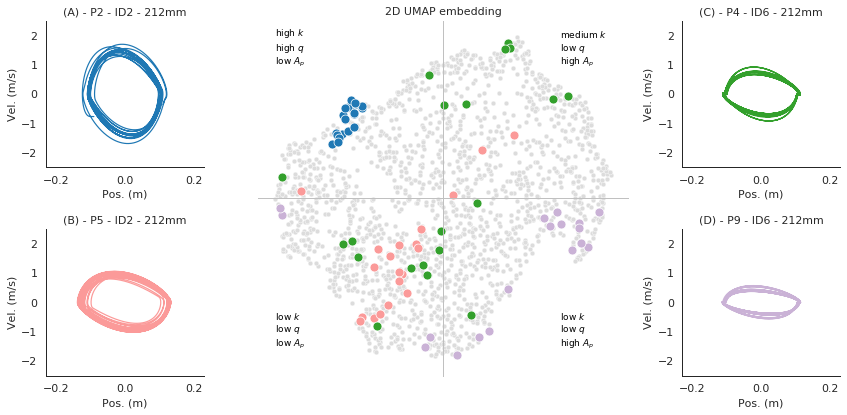

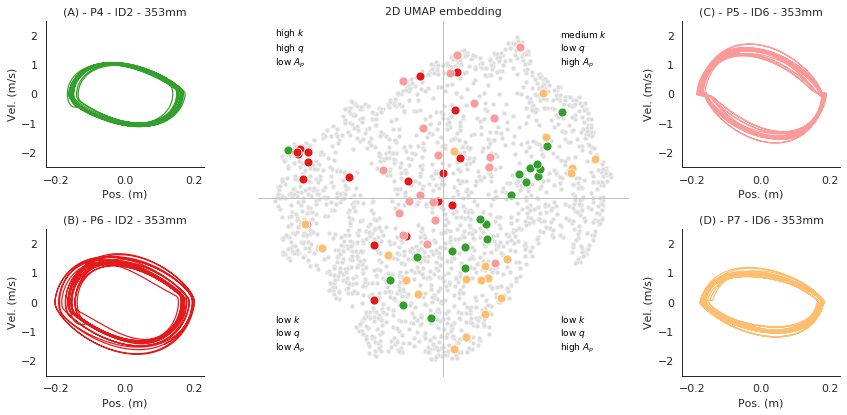

In [6]:
# FIGURE ---------------------------------------------------------------------

# --- Function definitions and defaults

def phase_planes(part, data, ID, xlim_l, xlim_r, ylim_l, ylim_r, labels_size):
    plt.plot(data[ID][0], data[ID][1], c=palette_participant[part-1])
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.set_xlabel('Pos. (m)', fontsize=labels_size)
    ax.set_ylabel('Vel. (m/s)', fontsize=labels_size)
    ax.set_xlim([xlim_l, xlim_r])
    ax.set_ylim([ylim_l, ylim_r])
    ax.tick_params(axis='x', labelsize=labels_size)
    ax.tick_params(axis='y', labelsize=labels_size)
    return ax

def scatter_participant(part, data_x, data_y, data_UMAP, palette_participant, ID, Distance, point_size):
    sns.scatterplot( x=data_x, y=data_y, palette=palette_participant, color=palette_participant[part-1],
        data=data_UMAP[(data_UMAP.Participant == part) & (data_UMAP.ID == ID) & (data_UMAP.Distance == Distance)],
        s=point_size, ax=ax0)

point_size = 80
Distance = 765
Distance_mm = '212'

# --- Figure for 212mm

grid = plt.GridSpec(2, 4)
plt.subplots(figsize=(12, 6))

ax0 = plt.subplot(grid[:2, 1:3])

# --- Scatterplots for the embedding
sns.scatterplot(x=x_umap, y=y_umap, color='gainsboro', data=dfID_umap, ax=ax0)

# --- Scatterplots for the participants
part = 2; ID = 2
scatter_participant(part,x_umap, y_umap, dfID_umap, palette_participant, ID, Distance, point_size)

part = 5; ID = 2
scatter_participant(part,x_umap, y_umap, dfID_umap, palette_participant, ID, Distance, point_size)

part = 4; ID = 6
scatter_participant(part,x_umap, y_umap, dfID_umap, palette_participant, ID, Distance, point_size)

part = 9; ID = 6
scatter_participant(part,x_umap, y_umap, dfID_umap, palette_participant, ID, Distance, point_size)

ax0.set_title('2D UMAP embedding', fontsize=labels_size)
ax0.spines['left'].set_position('center')
ax0.spines['bottom'].set_position('center')
ax0.spines['left'].set_color('silver')
ax0.spines['bottom'].set_color('silver')

min_x = min(dfID_umap[x_umap])
max_x = max(dfID_umap[x_umap])
min_y = min(dfID_umap[y_umap])
max_y = max(dfID_umap[y_umap])

ax0.spines['right'].set_color('none')
ax0.spines['top'].set_color('none')
ax0.set(xticklabels=[], yticklabels=[])
ax0.set(xlabel=None, ylabel=None)

# bottom-left
ax0.text(min_x, min_y+0.5, 'low $k$\nlow $q$\nlow $A_p$', fontsize=9, color="black")

# top-left
ax0.text(min_x, max_y-1.5, 'high $k$\nhigh $q$\nlow $A_p$', fontsize=9, color="black")

# top-right
ax0.text(max_x-4, max_y-1.5, 'medium $k$\nlow $q$\nhigh $A_p$', fontsize=9, color="black")

# bottom-right
ax0.text(max_x-4, min_y+0.5, 'low $k$\nlow $q$\nhigh $A_p$', fontsize=9, color="black")

# --- Phase planes

part = 2
ID = 0 # This is ID 2
df_765, df_1275 = phase_trajectories(participants[part-1])
ax = plt.subplot(grid[0, 0])
ax = phase_planes(part, df_765, ID, xlim_l, xlim_r, ylim_l, ylim_r, labels_size)
ax.set_title('(A) - P'+str(part)+' - ID2 - 212mm', fontsize=labels_size)
    
part = 5
ID = 0 # This is ID 2
df_765, df_1275 = phase_trajectories(participants[part-1])
# ax = plt.subplot(grid[1, 0], sharex=ax1, sharey=ax1)
ax = plt.subplot(grid[1, 0])
ax = phase_planes(part, df_765, ID, xlim_l, xlim_r, ylim_l, ylim_r, labels_size)
ax.set_title('(B) - P'+str(part)+' - ID2 - 212mm', fontsize=labels_size)

part = 4
ID = 2 # This is ID 6
df_765, df_1275 = phase_trajectories(participants[part-1])
ax = plt.subplot(grid[0, 3])
ax = phase_planes(part, df_765, ID, xlim_l, xlim_r, ylim_l, ylim_r, labels_size)
ax.set_title('(C) - P'+str(part)+' - ID6 - 212mm', fontsize=labels_size)

part = 9
ID = 2 # This is ID 6
df_765, df_1275 = phase_trajectories(participants[part-1])
ax = plt.subplot(grid[1, 3])
ax = phase_planes(part, df_765, ID, xlim_l, xlim_r, ylim_l, ylim_r, labels_size)
ax.set_title('(D) - P'+str(part)+' - ID6 - 212mm', fontsize=labels_size)
                   
plt.tight_layout()

# --- Figure for 353mm

Distance = 1275
Distance_mm = '353'

grid = plt.GridSpec(2, 4)
plt.subplots(figsize=(12, 6))

ax0 = plt.subplot(grid[:2, 1:3])

# --- Scatterplots for the embedding
sns.scatterplot(x=x_umap, y=y_umap, color='gainsboro', data=dfID_umap, ax=ax0)

# --- Scatterplots for the participants
part = 4; ID = 2
scatter_participant(part,x_umap, y_umap, dfID_umap, palette_participant, ID, Distance, point_size)

part = 6; ID = 2
scatter_participant(part,x_umap, y_umap, dfID_umap, palette_participant, ID, Distance, point_size)

part = 5; ID = 6
scatter_participant(part,x_umap, y_umap, dfID_umap, palette_participant, ID, Distance, point_size)

part = 7; ID = 6
scatter_participant(part,x_umap, y_umap, dfID_umap, palette_participant, ID, Distance, point_size)

ax0.set_title('2D UMAP embedding', fontsize=labels_size)
ax0.spines['left'].set_position('center')
ax0.spines['bottom'].set_position('center')
ax0.spines['left'].set_color('silver')
ax0.spines['bottom'].set_color('silver')

min_x = min(dfID_umap[x_umap])
max_x = max(dfID_umap[x_umap])
min_y = min(dfID_umap[y_umap])
max_y = max(dfID_umap[y_umap])

ax0.spines['right'].set_color('none')
ax0.spines['top'].set_color('none')
ax0.set(xticklabels=[], yticklabels=[])
ax0.set(xlabel=None, ylabel=None)

# bottom-left
ax0.text(min_x, min_y+0.5, 'low $k$\nlow $q$\nlow $A_p$', fontsize=9, color="black")

# top-left
ax0.text(min_x, max_y-1.5, 'high $k$\nhigh $q$\nlow $A_p$', fontsize=9, color="black")

# top-right
ax0.text(max_x-4, max_y-1.5, 'medium $k$\nlow $q$\nhigh $A_p$', fontsize=9, color="black")

# bottom-right
ax0.text(max_x-4, min_y+0.5, 'low $k$\nlow $q$\nhigh $A_p$', fontsize=9, color="black")

part = 4
ID = 0 # This is ID 2
df_765, df_1275 = phase_trajectories(participants[part-1])
ax = plt.subplot(grid[0, 0])
ax = phase_planes(part, df_1275, ID, xlim_l, xlim_r, ylim_l, ylim_r, labels_size)
ax.set_title('(A) - P'+str(part)+' - ID2 - 353mm', fontsize=labels_size)

part = 6
ID = 0 # This is ID 2
df_765, df_1275 = phase_trajectories(participants[part-1])
# ax = plt.subplot(grid[1, 0], sharex=ax, sharey=ax)
ax = plt.subplot(grid[1, 0])
ax = phase_planes(part, df_1275, ID, xlim_l, xlim_r, ylim_l, ylim_r, labels_size)
ax.set_title('(B) - P'+str(part)+' - ID2 - 353mm', fontsize=labels_size)

part = 5
ID = 2 # This is ID 
df_765, df_1275 = phase_trajectories(participants[part-1])
ax = plt.subplot(grid[0, 3])
ax = phase_planes(part, df_1275, ID, xlim_l, xlim_r, ylim_l, ylim_r, labels_size)
ax.set_title('(C) - P'+str(part)+' - ID6 - 353mm', fontsize=labels_size)

part = 7
ID = 2 # This is ID 
df_765, df_1275 = phase_trajectories(participants[part-1])
ax = plt.subplot(grid[1, 3])
ax = phase_planes(part, df_1275, ID, xlim_l, xlim_r, ylim_l, ylim_r, labels_size)
ax.set_title('(D) - P'+str(part)+' - ID6 - 353mm', fontsize=labels_size)

plt.tight_layout()

### 3.4 Two dimensional embedding coloured by participant for all IDs and for a distance of 212 mm

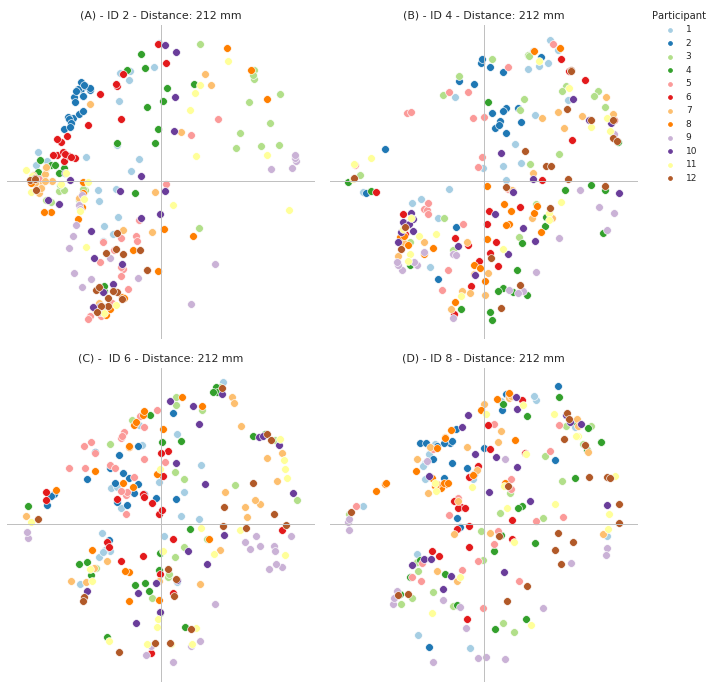

In [7]:
# FIGURE ---------------------------------------------------------------------

point_size = 60
Distance = 765
Distance_mm = '212'

def scatter_participant_all(participants, data_x, data_y, data_UMAP, palette_participant, ID, Distance, point_size):
    for i in participants:
        sns.scatterplot(x=data_x, y=data_y, palette=palette_participant, color=palette_participant[int(i)-1],
        data=data_UMAP[(data_UMAP.Participant == int(i)) & (data_UMAP.ID == ID) & (data_UMAP.Distance == Distance)],
        s=point_size, ax=ax)
    
    ax.spines['left'].set_position('center')
    ax.spines['bottom'].set_position('center')
    ax.spines['left'].set_color('silver')
    ax.spines['bottom'].set_color('silver')

    min_x = min(data_UMAP[x_umap])
    max_x = max(data_UMAP[x_umap])
    min_y = min(data_UMAP[y_umap])
    max_y = max(data_UMAP[y_umap])
    
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.set(xticklabels=[], yticklabels=[])
    ax.set(xlabel=None, ylabel=None)
    
    return ax
        
grid = plt.GridSpec(2, 2)
plt.subplots(figsize=(10, 10))

# --- ID 2
ID = 2
ax = plt.subplot(grid[0, 0])
ax = scatter_participant_all(participants, x_umap, y_umap, dfID_umap, palette_participant, ID, Distance, point_size)
ax.set_title('(A) - ID 2 - Distance: '+Distance_mm+' mm', fontsize=labels_size)

# --- ID 4
ID = 4
ax = plt.subplot(grid[0, 1])
ax = scatter_participant_all(participants, x_umap, y_umap, dfID_umap, palette_participant, ID, Distance, point_size)
ax.set_title('(B) - ID 4 - Distance: '+Distance_mm+' mm', fontsize=labels_size)

for labels in participants:
       plt.scatter([], [], c=[sns.color_palette(palette_participant)[int(labels)-1]], label=labels)

lg = ax.legend(prop={'size': 9}, frameon=False, scatterpoints=1,
                markerscale=0.8, loc='center right',
                bbox_to_anchor=(1.25, 0.77), ncol=1)
lg.set_title('Participant', prop={'size': 10})

# --- ID 6
ID = 6
ax = plt.subplot(grid[1, 0])
ax = scatter_participant_all(participants, x_umap, y_umap, dfID_umap, palette_participant, ID, Distance, point_size)
ax.set_title('(C) -  ID 6 - Distance: '+Distance_mm+' mm', fontsize=labels_size)

# --- ID 8
ID = 8
ax = plt.subplot(grid[1, 1])
ax = scatter_participant_all(participants, x_umap, y_umap, dfID_umap, palette_participant, ID, Distance, point_size)
ax.set_title('(D) - ID 8 - Distance: '+Distance_mm+' mm', fontsize=labels_size)

plt.tight_layout()

### 3.5 Kernel density estimates for all participants and IDs

In [ ]:
# FIGURE ---------------------------------------------------------------------

color_by = 'Participant'
Distance = 765   # 765 or 1275
palette_scatter = 'Paired'
n_colors = 12
no_columns = 2
label_list = participants
bbox_x = 1.2; bbox_y = 0.75
bbox_x_kde = 1.08; bbox_y_kde = 0.65

if Distance == 765: Distance_mm = '212'
elif Distance == 1275: Distance_mm = '353'
else: Distance_mm = '212'

def kde_participant_all(x_data, data_UMAP, color_by, palette_scatter, ID, Distance, n_colors):
    sns.kdeplot( x=x_data, data=data_UMAP[(data_UMAP.ID == ID) & (data_UMAP.Distance == Distance)],
        hue=color_by, palette=sns.color_palette(palette_scatter, n_colors=n_colors), cut=3, lw=2,
        ax=ax)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.set_title('ID '+str(ID), y=1.0)
    ax.set_xlabel('')
    ax.set_ylabel('KDE')
    
    return ax
    
grid = plt.GridSpec(4, 1, hspace=0.5)
plt.subplots(figsize=(10, 12))

# --- ID 2
ID = 2
ax = plt.subplot(grid[0, 0])
ax = kde_participant_all(x_umap, dfID_umap, color_by, palette_scatter, ID, Distance, n_colors)
for labels in label_list:
     plt.plot([], [], c=sns.color_palette(palette_scatter)[int(labels)-1], label=labels)
ax.legend(title=color_by, title_fontsize=12, prop={'size': 10}, loc='center right',
           bbox_to_anchor=(bbox_x_kde, bbox_y_kde), frameon=False, ncol=no_columns)        
        
# --- ID 4
ID = 4
ax = plt.subplot(grid[1, 0])
ax = kde_participant_all(x_umap, dfID_umap, color_by, palette_scatter, ID, Distance, n_colors)
ax.legend(prop={'size': 10}, loc='center right', bbox_to_anchor=(bbox_x_kde, bbox_y_kde),
               frameon=False, ncol=no_columns)

# --- ID 6
ID = 6
ax = plt.subplot(grid[2, 0])
ax = kde_participant_all(x_umap, dfID_umap, color_by, palette_scatter, ID, Distance, n_colors)
ax.legend(prop={'size': 10}, loc='center right', bbox_to_anchor=(bbox_x_kde, bbox_y_kde),
               frameon=False, ncol=no_columns)

# --- ID 8
ID = 8
ax = plt.subplot(grid[3, 0])
ax = kde_participant_all(x_umap, dfID_umap, color_by, palette_scatter, ID, Distance, n_colors)
ax.legend(prop={'size': 10}, loc='center right', bbox_to_anchor=(bbox_x_kde, bbox_y_kde),
               frameon=False, ncol=no_columns)

if normalize_umap is True:
    plt.suptitle('Reduced parameter set - Normalised data - '+str(n_comp)+'D embedding - Min. Distance: '+str(min_d)+'\nDistance between targets: '+Distance_mm+'mm',
                 fontsize=14, fontweight='bold', y=0.96)
else:
    plt.suptitle('Reduced parameter set - Raw data - '+str(n_comp)+'D embedding - Min. Distance '+str(min_d)+'\nDistance between targets: '+Distance_mm+'mm',
                 fontsize=14, fontweight='bold', y=0.96)